In [1]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import dotenv
import os
dotenv.load_dotenv()

from revert import models
from revert import infusion

# Pulse Encoder

In this notebook, we train an encoder $f : X \to Z$ to learn stable morphological features of ICP pulse waveforms. 

### 1. Invariant Augmentations

The latent pulse representation vector $z \in Z$ is invariant with respect to a certain set of _invariant_ (or _positive_) _augmentations_ acting on the input pulses $x \in X$, for instance:
- vertical shifts (mean ICP fluctuations),
- vertical scalings (pulse amplitude fluctuations),
- gaussian noise (measurement fluctuations),
- ...
- compositions of the above augmentations.

In [2]:
from revert import transforms

datadir   = os.environ['INFUSION_DATASETS']
data      = torch.load(os.path.join(datadir, 'baseline-no_shunt.pt'))

# Extracted pulses : [1174, 64, 128]
pulses    = data['pulses']
# Shuffled pulses  : [1174 * 64, 128]
shuffle   = transforms.Shuffle(0)
dset      = shuffle(pulses[:1000].view([-1, 128]))
dset_val  = shuffle(pulses[1000:].view([-1, 128]))
print('dataset shape :', list(dset.shape))

# Invariant augmentations 
from revert.transforms import VShift, VScale, Noise

T = [VShift(.5),
     VScale(1.),
     Noise(.15),
     Noise(.1) @ VShift(.5) @ VScale(.5)]

dataset shape : [64000, 128]


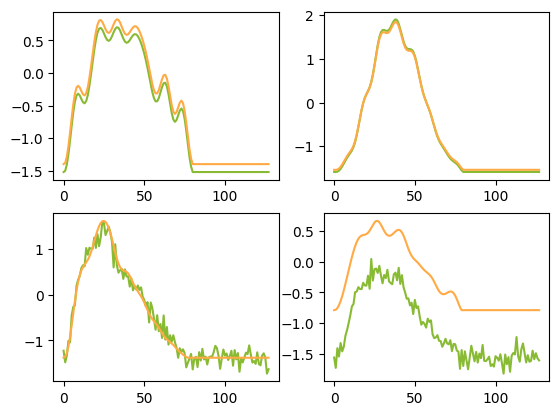

In [3]:
# Augmented DataLoader 
subset = transforms.Shuffle(0)(pulses.view([-1, 128]))[:64]
loader = transforms.AugmentLoader(subset[:64], T, 4)
x_t = [x for x in loader]
x_t[0].shape

for i, xs in enumerate(x_t[0]):
    plt.subplot(2, 2, i+1)
    plt.plot(xs[1], color='#8b3')
    plt.plot(xs[0], color='#fa4')


### 2. Encoder Architecture

We train a 2-layer convolutional pulse encoder $f : X \to Z$ with the VICReg loss. 
An expanding head $h : Z \to Y$ is trained with the encoder but dropped after training, 
following the original strategy of Barlow Twins. 

In [4]:
dx, dy, dz = 64, 8, 32

name    = f'VICReg-{dx}:{dy}:{dz}'
logdir  = os.path.join(os.environ['REVERT_LOGS'], 'pulse-encoder')

downsample = nn.AvgPool1d(128 // dx)

model_layers = [[1, 64, dy],
               [dx, 16, 1],
               [8,  16]]

head_layers = [[dy, 16, dz],
               [1,  1,  1],
               [1,  1]]

model   = models.ConvNet(model_layers) @ downsample
head    = models.View([dz]) @ models.ConvNet(head_layers)

twins = models.VICReg(head @ model, 
                      coeffs=(1, 1, .1))

# tensorboard directory
twins.write_to(os.path.join(logdir, name))

The following callbacks plot to tensorboard the validation loss and 
an image of the cross-correlation matrix after each epoch. 

In [5]:
@twins.epoch
def dump_loss(tag, data, epoch):
    """ Loss on validation dataset """
    with torch.no_grad():
        x = shuffle(data['val'])[:2048]
        y = twins(loader.augment(x))
        loss = twins.loss(y)
        twins.write(f'Loss validation/{tag}', loss, epoch)
        twins.free()

@twins.epoch
def dump_xcorr(tag, data, epoch):
    """ Cross correlation matrix of expander output """
    n = f'Cross correlation/{tag}'
    x = shuffle(data['val'])[:2048]
    y = twins(loader.augment(x))
    C = twins.xcorr(y)
    twins.writer.add_image(n, (1 + C) / 2, global_step=epoch, dataformats='HW')
    twins.free(C)

The `.fit` method implements the main training loop, taking care of boilerplate code in the update of parameters. The `optim` and `lr` parameters accept pytorch optimizers (Adam by default) and learning rate schedulers. 

In [6]:
from torch.optim import Adam
from torch.optim.lr_scheduler import ExponentialLR

optim = Adam(twins.parameters(), lr=5e-4)
lr    = ExponentialLR(optim, .9)
                
twins.fit(transforms.AugmentLoader(dset, T, 256),
          optim=optim,
          lr=lr,
          epochs=30, 
          val=dset_val,
          tag='episode 1')

statedir = os.environ['REVERT_MODELS']
twins.save(os.path.join(statedir, name) + '.pt')

epoch: 100%|██████████| 30/30 [08:45<00:00, 17.52s/it]
